In [23]:
%reload_ext autoreload
%autoreload 2
import torch 
from torch import nn
from torch.nn import functional as F
import math
import sys
import os
import re
import random
import collections
sys.path.append('../../pytools')
import d2l
d2l.set_gpu_device()

CUDA 可用，并且显存按需增长已启用。


In [24]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [25]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [26]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [27]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 7533.2 tokens/sec on cuda:0


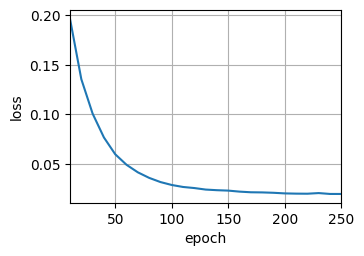

In [28]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [29]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000
